In [1]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-vd__412d
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-vd__412d
  Resolved https://www.github.com/mouseland/cellpose.git to commit 17fb25f40055ec2636aa708dc4cf6625b8b4735d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 45.2 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.8-py3-none-any.whl size=212051 sha256=bb527be1e04dd5354a6ba930b295ff4571ab8a2e54a1dc1a57af67b978513cef
  Stored in directory: /tmp/pip-ephem-wheel-cache-dklb_34t/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


In [2]:
import os
import numpy as np
import pandas as pd

from skimage import io
from skimage.measure import regionprops
from tqdm import tqdm

from PIL import Image
from cellpose import models


INPUT_IMAGE_DIR   = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3"   # <--- your folder of 2-channel images
OUTPUT_PATCH_DIR  = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel"   # <--- where patches go
OUTPUT_META_CSV   = "/content/drive/MyDrive/FYP/cell_patches_meta.csv"  # optional, for bookkeeping

CELLPOSE_MODEL_PATH = "/content/drive/MyDrive/FYP/cellpose models/new_model"  # <--- your custom model
USE_GPU = True
TARGET_SIZE = (224, 224)   # ViT input size
BBOX_MARGIN = 5            # padding around cell bbox
FOCI_CHANNEL_INDEX = 1     # second channel (0-based)

os.makedirs(OUTPUT_PATCH_DIR, exist_ok=True)


In [3]:
from cellpose import models
cp_model = models.CellposeModel(gpu=USE_GPU, pretrained_model=CELLPOSE_MODEL_PATH)


**helpers to load 2-channel image and pick foci channel**

In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import io
from skimage.measure import regionprops
from PIL import Image

def load_foci_channel(img_path, foci_channel_index=1):
    """
    Load a multi-channel TIFF and return the foci channel as 2D array.
    Assumes either (C, H, W) or (H, W, C).
    """
    img = io.imread(img_path)

    if img.ndim == 2:
        return img

    if img.ndim == 3:
        # (C, H, W)
        if img.shape[0] <= 4:
            foci = img[foci_channel_index]
        # (H, W, C)
        elif img.shape[-1] <= 4:
            foci = img[..., foci_channel_index]
        else:
            raise ValueError(f"Unexpected image shape {img.shape} for {img_path}")
    else:
        raise ValueError(f"Unsupported image ndim={img.ndim} for {img_path}")

    return foci


def build_patches_from_folder(
    input_folder,
    output_folder,
    meta_csv_path,
    foci_channel_index=1,
    min_area=100,
    margin=4
):
    os.makedirs(output_folder, exist_ok=True)

    image_paths = sorted([
        os.path.join(input_folder, f)
        for f in os.listdir(input_folder)
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
    ])

    print(f"Found {len(image_paths)} images in {input_folder}")

    meta_rows = []

    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            foci_img = load_foci_channel(img_path, foci_channel_index=foci_channel_index)
            masks = segment_cells(foci_img)

            if masks.max() == 0:
                continue

            props = regionprops(masks)
            stem = Path(img_path).stem
            for prop in props:
                if prop.area < min_area:
                    continue

                y0, x0, y1, x1 = prop.bbox
                y0 = max(y0 - margin, 0)
                x0 = max(x0 - margin, 0)
                y1 = min(y1 + margin, masks.shape[0])
                x1 = min(x1 + margin, masks.shape[1])

                patch_img = foci_img[y0:y1, x0:x1]
                patch_mask_bool = (masks[y0:y1, x0:x1] == prop.label)

                patch_img_clean = patch_img.copy()
                patch_img_clean[~patch_mask_bool] = 0
                p = patch_img_clean.astype(np.float32)
                p = p - p.min()

                if p.max() > 0:
                    p = p / p.max()
                p = (p * 255).astype(np.uint8)

                patch_rgb = np.stack([p, p, p], axis=-1)  # (H, W, 3)
                patch_mask_uint8 = (patch_mask_bool.astype(np.uint8) * 255)

                cell_id = prop.label
                patch_filename = f"{stem}_cell{cell_id:03d}.png"
                mask_filename  = f"{stem}_cell{cell_id:03d}_mask.png"

                patch_path = os.path.join(output_folder, patch_filename)
                mask_path  = os.path.join(output_folder, mask_filename)

                Image.fromarray(patch_rgb).save(patch_path)
                Image.fromarray(patch_mask_uint8).save(mask_path)

                meta_rows.append({
                    "source_image": img_path,
                    "patch_path": patch_path,
                    "mask_path": mask_path,
                    "cell_label": int(cell_id),
                    "area": int(prop.area),
                    "bbox_y0": int(y0),
                    "bbox_x0": int(x0),
                    "bbox_y1": int(y1),
                    "bbox_x1": int(x1),
                })

        except Exception as e:
            print(f"ERROR processing {img_path}: {e}")
            continue

    meta_df = pd.DataFrame(meta_rows)
    meta_df.to_csv(meta_csv_path, index=False)
    print("Saved patch metadata to:", meta_csv_path)
    print("Total patches created:", len(meta_df))
    return meta_df


**Cellpose segmentation + patch extraction for one image**

In [5]:
def segment_cells(foci_img):
    """
    Run Cellpose on a single-channel foci image.
    Returns 'masks' with integer labels (0 = background, 1..N = cells).
    """
    result = cp_model.eval(
        foci_img,
        channels=[0, 0],
        progress=False
    )
    masks = result[0]
    return masks


In [6]:
def extract_cell_patches_from_image(
    img_path,
    out_dir=OUTPUT_PATCH_DIR,
    target_size=TARGET_SIZE,
    margin=BBOX_MARGIN,
    foci_channel_index=FOCI_CHANNEL_INDEX
):
    """
    For a single 2-channel image:
      - load foci channel
      - segment cells with Cellpose
      - create masked patches and save them

    Returns a list of dicts with metadata for each patch.
    """
    foci = load_foci_channel(img_path, foci_channel_index=foci_channel_index)  # (H, W)
    masks = segment_cells(foci)                                               # (H, W)

    H, W = foci.shape
    meta_rows = []

    props = regionprops(masks)
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    cell_idx = 0
    for prop in props:
        label_id = prop.label

        # bounding box
        minr, minc, maxr, maxc = prop.bbox

        # add margin, clamp to image size
        minr = max(minr - margin, 0)
        minc = max(minc - margin, 0)
        maxr = min(maxr + margin, H)
        maxc = min(maxc + margin, W)

        # crop foci channel + mask
        patch = foci[minr:maxr, minc:maxc]
        mask_patch = (masks[minr:maxr, minc:maxc] == label_id).astype(np.float32)

        # black out background
        patch_masked = patch * mask_patch

        # normalize to 0–255
        p_min, p_max = patch_masked.min(), patch_masked.max()
        if p_max > p_min:
            patch_norm = (patch_masked - p_min) / (p_max - p_min)
        else:
            patch_norm = np.zeros_like(patch_masked)

        patch_uint8 = (patch_norm * 255).astype(np.uint8)  # (h, w)

        # make 3-channel for ViT
        patch_rgb = np.stack([patch_uint8] * 3, axis=-1)   # (h, w, 3)

        # resize to TARGET_SIZE
        pil_img = Image.fromarray(patch_rgb)
        pil_img = pil_img.resize(target_size, resample=Image.BILINEAR)

        patch_filename = f"{base_name}_cell{cell_idx:03d}.png"
        patch_path = os.path.join(out_dir, patch_filename)
        pil_img.save(patch_path)

        meta_rows.append({
            "patch_path": patch_path,
            "src_image_path": img_path,
            "cell_label_id": int(label_id),
        })

        cell_idx += 1

    return meta_rows


**Walk a folder, process all images, save patches**

In [7]:
def list_image_files(root_dir, exts=(".tif", ".tiff", ".png", ".jpg", ".jpeg")):
    """
    Recursively list all image files in root_dir with given extensions.
    """
    files = []
    for r, _, fs in os.walk(root_dir):
        for f in fs:
            if f.lower().endswith(exts):
                files.append(os.path.join(r, f))
    return sorted(files)


In [14]:
def build_patches_from_folder(
    input_dir=INPUT_IMAGE_DIR,
    out_dir=OUTPUT_PATCH_DIR,
    out_meta_csv=OUTPUT_META_CSV
):
    image_paths = list_image_files(input_dir)
    print("Found", len(image_paths), "images in", input_dir)

    all_meta = []

    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            meta_rows = extract_cell_patches_from_image(
                img_path,
                out_dir=out_dir,
                target_size=TARGET_SIZE,
                margin=BBOX_MARGIN,
                foci_channel_index=FOCI_CHANNEL_INDEX
            )
            all_meta.extend(meta_rows)
        except Exception as e:
            print(f"ERROR processing {img_path}: {e}")

    meta_df = pd.DataFrame(all_meta)
    meta_df.to_csv(out_meta_csv, index=False)
    print("Saved patch metadata to:", out_meta_csv)
    print("Total patches created:", len(meta_df))
    return meta_df


In [10]:
from skimage import io
img_path = "/content/drive/MyDrive/FYP/1Gy_10Gy_gH2AX_TimeCourse/10Gy_gH2AX_1Hr.tif"

foci = load_foci_channel(img_path)
print("foci shape:", foci.shape)

masks = segment_cells(foci)
print("masks shape:", masks.shape, "unique labels:", np.unique(masks)[:10])
print(len(np.unique(masks)))

foci shape: (2160, 2560)
masks shape: (2160, 2560) unique labels: [0 1 2 3 4 5 6 7 8 9]
148


In [15]:
input_folder  = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3"
output_folder = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel"
meta_csv_path = "/content/drive/MyDrive/FYP/cell_patches_meta.csv"

meta_df = build_patches_from_folder(
    input_folder=input_folder,
    output_folder=output_folder,
    meta_csv_path=meta_csv_path,
    foci_channel_index=0,  # second channel
    min_area=100,
    margin=4,
)

TypeError: build_patches_from_folder() got an unexpected keyword argument 'input_folder'

**224×224 patches + masks**

In [17]:
import os
import glob
import numpy as np
from tqdm import tqdm

import tifffile as tiff
from cellpose import models
from skimage.measure import regionprops
from PIL import Image

# -----------------------
# CONFIG
# -----------------------

input_folder  = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3"
output_folder = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel"
os.makedirs(output_folder, exist_ok=True)

custom_model_path = "/content/drive/MyDrive/FYP/cellpose models/new_model"  # <- change
model = models.CellposeModel(pretrained_model=custom_model_path, gpu=True)

# Which channel index is foci (0-based)
FOCI_CH = 1          # foci channel
PATCH_SIZE = 224
MARGIN = 5

OVERWRITE_ORIGINALS = False

def load_multichannel_tif(path):
    arr = tiff.imread(path)

    if arr.ndim == 3:
        if arr.shape[0] <= 4:  # (C, H, W)
            arr = np.transpose(arr, (1, 2, 0))  # (H, W, C)
    elif arr.ndim == 2:
        # single-channel
        return arr, arr

    foci_img = arr[..., FOCI_CH]
    return foci_img, arr


all_images = sorted(glob.glob(os.path.join(input_folder, "*.tif")))
print(f"Found {len(all_images)} images in {input_folder}")

total_patches = 0

for img_path in tqdm(all_images, desc="Processing images"):
    base = os.path.splitext(os.path.basename(img_path))[0]

    try:
        foci_img, arr = load_multichannel_tif(img_path)

        result = model.eval(
            foci_img,
            channels=[0, 0],
            diameter=None
        )

        if isinstance(result, (list, tuple)):
            if len(result) == 4:
                masks, flows, styles, diams = result
            elif len(result) == 3:
                masks, flows, styles = result
                diams = None
            else:
                raise RuntimeError(f"Unexpected number of outputs from Cellpose: {len(result)}")
        else:
            raise RuntimeError("Unexpected output type from Cellpose eval")

        if masks is None or masks.max() == 0:
            print(f"No cells found in {img_path}")
            continue

        props = regionprops(masks)

        for cell_id, prop in enumerate(props, start=1):
            y0, x0, y1, x1 = prop.bbox

            y0 = max(y0 - MARGIN, 0)
            x0 = max(x0 - MARGIN, 0)
            y1 = min(y1 + MARGIN, masks.shape[0])
            x1 = min(x1 + MARGIN, masks.shape[1])

            # crop foci patch + mask patch
            patch_img = foci_img[y0:y1, x0:x1]
            patch_mask = (masks[y0:y1, x0:x1] == prop.label).astype(np.uint8) * 255

            # normalize foci to 0–255 uint8
            p = patch_img.astype(np.float32)
            p -= p.min()
            if p.max() > 0:
                p /= p.max()
            p = (p * 255).astype(np.uint8)

            patch_pil = Image.fromarray(p, mode="L")
            mask_pil  = Image.fromarray(patch_mask, mode="L")

            # resize to 224×224
            patch_pil = patch_pil.resize((PATCH_SIZE, PATCH_SIZE), Image.BILINEAR)
            mask_pil  = mask_pil.resize((PATCH_SIZE, PATCH_SIZE), Image.NEAREST)

            patch_name = f"{base}_cell{cell_id:03d}.png"
            mask_name  = f"{base}_cell{cell_id:03d}_mask.png"

            if OVERWRITE_ORIGINALS:
                patch_save_path = img_path
                mask_save_path  = os.path.join(
                    os.path.dirname(img_path),
                    f"{base}_mask.png"
                )
            else:
                patch_save_path = os.path.join(output_folder, patch_name)
                mask_save_path  = os.path.join(output_folder, mask_name)

            patch_pil.save(patch_save_path)
            mask_pil.save(mask_save_path)

            total_patches += 1

    except Exception as e:
        print(f"ERROR processing {img_path}: {e}")
        continue

print("Total 224×224 patches created:", total_patches)
print("Saved patches to:", output_folder)

Found 66 images in /content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3


Processing images:   0%|          | 0/66 [00:00<?, ?it/s]WARNING:cellpose.models:channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
/tmp/ipython-input-1049912484.py:121: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  patch_pil = Image.fromarray(p, mode="L")
/tmp/ipython-input-1049912484.py:122: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil  = Image.fromarray(patch_mask, mode="L")
Processing images: 100%|██████████| 66/66 [58:34<00:00, 53.25s/it]

Total 224×224 patches created: 5600
Saved patches to: /content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel


blackout the patches

In [18]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

# -----------------------
# CONFIG
# -----------------------
patch_folder = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel"  # <- change if needed

mask_paths = sorted(glob.glob(os.path.join(patch_folder, "*_mask.png")))
print(f"Found {len(mask_paths)} mask files in {patch_folder}")

num_updated = 0
num_skipped = 0

for mask_path in tqdm(mask_paths, desc="Blacking out non-cell regions"):
    base_no_ext = os.path.splitext(mask_path)[0]
    img_path = base_no_ext.replace("_mask", "") + ".png"

    if not os.path.exists(img_path):
        print(f"WARNING: image file not found for mask {mask_path}")
        num_skipped += 1
        continue

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    if img_arr.shape[:2] != mask_arr.shape[:2]:
        print(f"WARNING: size mismatch for {img_path} and {mask_path}, skipping.")
        num_skipped += 1
        continue

    mask_binary = (mask_arr > 0).astype(np.uint8)

    # If image is grayscale: (H, W)
    # If image is RGB: (H, W, 3) → broadcast mask
    if img_arr.ndim == 2:  # single channel
        img_blacked = img_arr * mask_binary
    elif img_arr.ndim == 3:  # multi-channel
        img_blacked = img_arr * mask_binary[..., None]
    else:
        print(f"Unexpected image shape {img_arr.shape} for {img_path}, skipping.")
        num_skipped += 1
        continue

    img_blacked_pil = Image.fromarray(img_blacked, mode=img.mode)

    img_blacked_pil.save(img_path)
    num_updated += 1

print(f"Done. Updated {num_updated} patches. Skipped {num_skipped}.")
print("All non-cell regions in those patches are now blacked out (using the masks).")


Found 5600 mask files in /content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel


Blacking out non-cell regions:   0%|          | 0/5600 [00:00<?, ?it/s]/tmp/ipython-input-3235254062.py:57: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_blacked_pil = Image.fromarray(img_blacked, mode=img.mode)
Blacking out non-cell regions: 100%|██████████| 5600/5600 [03:06<00:00, 30.06it/s]

Done. Updated 5600 patches. Skipped 0.
All non-cell regions in those patches are now blacked out (using the masks).


In [19]:
import os
import math
import shutil
from pathlib import Path

def chunk_images_into_subfolders(
    src_dir: str,
    dst_root: str,
    files_per_folder: int = 500,
    folder_prefix: str = "batch_",
    dry_run: bool = False,
    recursive: bool = False,
):
    """
    Move images from src_dir into subfolders under dst_root, each containing
    up to files_per_folder images.

    - src_dir: folder where the flat (or nested, if recursive=True) images live.
    - dst_root: folder where batch_xxxx subfolders will be created.
    """

    src = Path(src_dir).expanduser().resolve()
    dst = Path(dst_root).expanduser().resolve()

    if not src.exists() or not src.is_dir():
        raise ValueError(f"Not a valid source directory: {src}")

    if not dry_run:
        dst.mkdir(parents=True, exist_ok=True)

    exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff", ".webp", ".heic"}

    globber = src.rglob("*") if recursive else src.glob("*")
    files = [p for p in globber if p.is_file() and p.suffix.lower() in exts]

    files.sort(key=lambda p: p.name.lower())

    if not files:
        print(f"No image files found in: {src}")
        return

    total = len(files)
    num_folders = math.ceil(total / files_per_folder)
    print(f"Found {total} images. Creating {num_folders} subfolders "
          f"of up to {files_per_folder} files each in {dst}.")

    for i in range(num_folders):
        start = i * files_per_folder
        end = min(start + files_per_folder, total)
        chunk = files[start:end]

        subfolder = dst / f"{folder_prefix}{i+1:04d}"
        if not dry_run:
            subfolder.mkdir(parents=True, exist_ok=True)

        for p in chunk:
            dest = subfolder / p.name

            if dest.exists():
                stem, suf = p.stem, p.suffix
                k = 1
                while (subfolder / f"{stem}__dup{k}{suf}").exists():
                    k += 1
                dest = subfolder / f"{stem}__dup{k}{suf}"

            if dry_run:
                print(f"[DRY RUN] Move: {p} -> {dest}")
            else:
                shutil.move(str(p), str(dest))

        print(f"Created {subfolder.name}: {len(chunk)} files")

    print("Done.")


In [20]:
chunk_images_into_subfolders(
    src_dir="/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224_nuclie_channel",
    dst_root="/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224__nuclie_channel_batched",
    files_per_folder=500,
)


Found 11200 images. Creating 23 subfolders of up to 500 files each in /content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3_patches_224__nuclie_channel_batched.
Created batch_0001: 500 files
Created batch_0002: 500 files
Created batch_0003: 500 files
Created batch_0004: 500 files
Created batch_0005: 500 files
Created batch_0006: 500 files
Created batch_0007: 500 files
Created batch_0008: 500 files
Created batch_0009: 500 files
Created batch_0010: 500 files
Created batch_0011: 500 files
Created batch_0012: 500 files
Created batch_0013: 500 files
Created batch_0014: 500 files
Created batch_0015: 500 files
Created batch_0016: 500 files
Created batch_0017: 500 files
Created batch_0018: 500 files
Created batch_0019: 500 files
Created batch_0020: 500 files
Created batch_0021: 500 files
Created batch_0022: 500 files
Created batch_0023: 200 files
Done.


See channels

In [22]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

def visualize_two_channels(
    img_path,
    ch1=0,      # index of first channel to show
    ch2=1       # index of second channel to show
):
    """
    Visualize two channels of a multi-channel TIFF image side by side.
    Handles (C, H, W) and (H, W, C).
    """

    arr = tiff.imread(img_path)

    if arr.ndim == 2:
        raise ValueError("Image has only 1 channel (H, W). No multiple channels to visualize.")

    if arr.ndim == 3:
        if arr.shape[0] <= 4:
            arr = np.transpose(arr, (1, 2, 0))
    else:
        raise ValueError(f"Unexpected image shape {arr.shape}")

    n_channels = arr.shape[-1]
    print(f"Image shape: {arr.shape}  (H, W, C), channels = {n_channels}")

    if ch1 >= n_channels or ch2 >= n_channels:
        raise ValueError(f"Requested channels {ch1}, {ch2} but only {n_channels} channels available.")

    chan1 = arr[..., ch1]
    chan2 = arr[..., ch2]

    def norm_channel(x):
        x = x.astype(np.float32)
        x_min, x_max = x.min(), x.max()
        if x_max > x_min:
            x = (x - x_min) / (x_max - x_min)
        else:
            x = np.zeros_like(x, dtype=np.float32)
        return x

    chan1_n = norm_channel(chan1)
    chan2_n = norm_channel(chan2)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(chan1_n, cmap="gray")
    plt.title(f"Channel {ch1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(chan2_n, cmap="gray")
    plt.title(f"Channel {ch2}")
    plt.axis("off")

    plt.suptitle(f"{img_path}", fontsize=8)
    plt.tight_layout()
    plt.show()

Image shape: (2160, 2560, 2)  (H, W, C), channels = 2


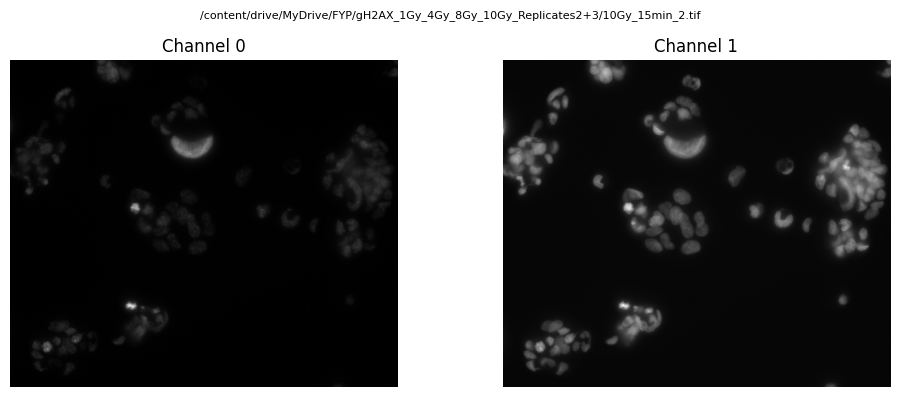

In [23]:
img_path = "/content/drive/MyDrive/FYP/gH2AX_1Gy_4Gy_8Gy_10Gy_Replicates2+3/10Gy_15min_2.tif"
visualize_two_channels(img_path, ch1=0, ch2=1)   # e.g. DNA = 0, foci = 1
